In [3]:
#导入关键的API
import time
import os
import matplotlib.pyplot as plt#在jupyter中运行必须要以inline形式展现，否则无法可视化
%matplotlib inline  
import skimage #用于保存图片且Q3.8中skimage.measure.compare_psnr()比较psnr
import numpy as np
import tensorflow as tf
import scipy
#注意：额外需要导入scipy.ndimage才能用于操作函数preprocess中input和input_的bicubic
import scipy.ndimage
import pdb 

In [3]:
#以下部分全部按照CW1_Guidance内容要求完成，每一步都按照Jupyter的console进行，以便Assesment检查
#Code Designer: Youmin XUE薛又岷
#Student ID: 180864371
#CW1_SRCNN——platform" python3.6.5 ;tensorflow 1.12

In [4]:
#=======TASK 1.Understanding image super-resolution=======

In [5]:
#Questions：
#1.image size和image resolution的概念：图像大小是图像的格式，例如255x255pixels, 而resolution确切的说是DPI(digital per image)
#2.灰度图是0-255之间非黑即白，有三通道灰度图也有单通道灰度图。单通道超分辨图片指的是Y、Cr、Cb、R、G、B这样类型的
#3.GroudTruth image在代码中是preprocess函数中定义的output，对应label_，对应于原始高分辨率图像(image with original high-resolution)
#    *值得注意的是：这里preprocess函数中，label_其实为经过bicubic处理后，再3倍放大的图像。
#4.如何度量结果：PSNR或者SSIM，峰值信噪比或者结构相似性。其实和MSE差不多，因为存在线性关系，所以PSNR越大越好

In [4]:
#代码部分：
#Ques1：
path = 'C:/Users/surface/Desktop/CW1_for_students/CW1_Handout_Template_code/tf-SRCNN/image/butterfly_GT.bmp'
butterfly = scipy.misc.imread(path)#利用imread函数读取三通道原始图像

C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [5]:
#Ques2:
np.shape(butterfly)#256x256x3 RGB

(256, 256, 3)

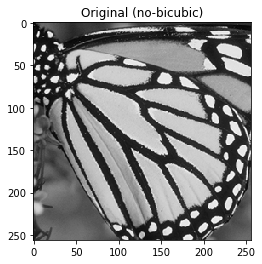

In [6]:
#Ques3:此处省略breakpoint,因为采用jupyter方式更为直观地表示并备注，若需要设置断点，键入pdb.set_trace()于对应的命令后一行
#方法一：
#参考公式(numpy矩阵点乘)：R*299/1000 + G*587/1000 + B*114/1000
butterfly_gray = np.dot(butterfly[...,:],[0.299,0.587,0.114])
#定义1x3的子图空间，因为后面代码需要展示groundtruth等图
#可以定义输出图像为YCrCb，因为paper中展示的均为灰度图像，故在此利用get_cmap变换图像为灰度图
plt.imshow(butterfly_gray, cmap=plt.get_cmap('gray'))
plt.title('Original (no-bicubic)')

#方法二：from PIL import image，利用API中的convert函数；当然，也可以利用cv2中的灰度处理（ITL未配置）
#方法三：from skimage import io
#gray = io.read(path,as_gray=True)
#io.imshow(gray)

C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


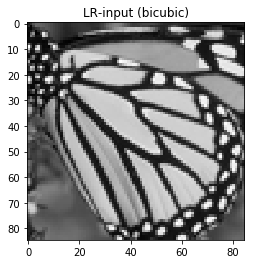

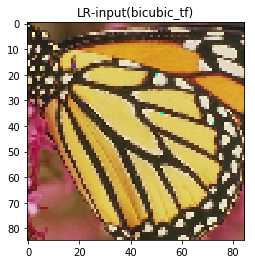

In [12]:
#Ques4:（这里我均为进行标准化处理，若需要，则需除以255）
#方法一：利用scipy.misc.imresize()方法实现bicubic
#3插值缩放处理后的低分辨率图像：
h,w = butterfly_gray.shape[:2]#读取图片的长宽
h_,w_ = int(h/3),int(w/3)#定义新的长宽（即三插值的维度）
bicubic_butterfly = scipy.misc.imresize(butterfly_gray, (h_,w_),interp='bicubic',mode='F')
#mode='F'不可少，否则图像会严重失真
plt.figure(1)
plt.imshow(bicubic_butterfly, cmap=plt.get_cmap('gray'))
plt.title('LR-input (bicubic)')


#方法二：适用tf.image.resize_images：但是input是三通道图并非灰度图
with tf.Session() as sess:
    bicubic_butterfly_tf = tf.image.resize_images(butterfly, [h_,w_],method=2)  #第一个参数为原始图像，第二个参数为图像大小，第三个参数给出了指定的算法
    bicubic_butterfly_tf = np.asarray(bicubic_butterfly_tf.eval(),dtype='uint8')#保持以整数形式存储，eval()执行字符串，返回表达式的值
    plt.figure(2)
    plt.imshow(bicubic_butterfly_tf)
    plt.title('LR-input(bicubic_tf)')#可以用来观察bicubic的缩放会对图像造成什么样的影响
    sess.close()

#两张图可见，图片分辨率极低

C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


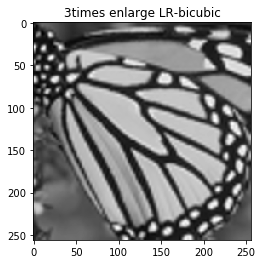

In [13]:
#Ques5: 利用上一步的结果进行处理
#将图像恢复成原来的样子
bicubic_butterfly_re = scipy.misc.imresize(bicubic_butterfly, (h,w), interp='bicubic',mode='F')
plt.imshow(bicubic_butterfly_re, cmap=plt.get_cmap('gray'))
plt.title('3times enlarge LR-bicubic')
#*注意：bicubic_butterfly_re != butterfly_gray，因为他们的数据结构一个是float一个是uint8
#显然图像变得平滑了

In [14]:
#===================Code自定义函数部分=====================
#Code自带函数：imread。再preprocess函数中调用，用于读取灰度图像并转换为YCbCr格式
def imread(path, is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

In [15]:
#Code自带函数：modcrop,也是Preprocess中调用的，判断图片是否是三通道后，为预处理3次插值bicubic做准备
def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

In [16]:
#Code自带的函数，进行标准化处理，对YCbCr格式的原始图像进行三次插值的缩小和放大
def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

  return input_, label_
#=======================Code自定义函数部分结束===========================

In [19]:
#======TASK 2.Understanding Deep Learning by Convolutional Neural Networks=======
#定义超参数：输入维度和输入图像大小
"""Set the image hyper parameters
"""
c_dim = 1
input_size = 255

In [20]:
#Questions：
#1.CNN的参数主要有filters(大小、个数),biases，epoch的次数，正则化惩罚因子，梯度下降步长。
    #超参数有:momentum中的alpha,belta。dropout中的keep_prob=0.5等
#2.以MSE为例，希望loss function(或cost)越小越好，证明泛化能力越强，即y_predict和y越相似。而在此SRCNN中，PSNR、SSIM越高越好，证明相似度越高
#3.同一层的不同filters用来提取不同类型的特征，但同一层中复杂度相似，例如filter_l1_1提取水平线条，filter_l2_2可能提取的就是垂直
    #不同层之间，随着网络加深，解读的feature map会更加地细节化。例如第一层是线条，接着就是纹理，然后是更加复杂的特征
#4.feature map就是每层中经过不同的filters提取出来的特征子图（不同通道），它可能只能辨识一些特定的特征，如上题所述。实为一个矩阵
#5.通过一行一行地scan image(patches)。利用stride、padding、filter_size、patch_size的公式：(n+2p-f)/stride + 1 = output_size

In [28]:
#代码部分：
#Ques1：
"""Load the pre-trained model file
"""
model_path='C:/Users/surface/Desktop/CW1_for_students/CW1_Handout_Template_code/tf-SRCNN/model/model.npy'
model = np.load(model_path, encoding='latin1').item()
#但是其实并不要用到model中的参数

#Ques2:设置filters的个数和大小：
                #weights:[f_size x f_size x channel,个数],标准差大小 <weights不能以0作为初始化，因为会造成计算结果相同。>
                #biases:初始化：0个数
    
# define the placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, [None, input_size, input_size, c_dim], name='inputs')

## ------ Add your code here: set the weight of three conv layers
# replace '0' with your hyper parameter numbers 
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
weights = {
    'w1': tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='w1'),#which means there are 64 numbers of 9x9x1 filters
    'w2': tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='w2'),#32 numbers of 1x1x64 filters
    'w3': tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')#just 1 of 5x5x32 filters
    }

biases = {
      'b1': tf.Variable(tf.zeros([64]), name='b1'),#<64>the number of bias depends on the number of filters in this layer
      'b2': tf.Variable(tf.zeros([32]), name='b2'),#<32> filters
      'b3': tf.Variable(tf.zeros([1]), name='b3')#<1> filter
    }

In [33]:
#初始化变量
que4_input = tf.Variable(tf.random_normal([1,19,19,1]))#define 1 random img with 9x9, 1 channel as the test of Ques4.5
init_task2 = tf.initialize_all_variables()
with tf.Session() as sess:
   sess.run(init_task2)
#Ques2
   #Ques2.3 Show the No.1 filters of layer_1. <Hint: index started from 0>
   w1_1 = sess.run(weights['w1'])[:,:,:,0]
   #print(w1_1)    #assesment时候如果需要展示,直接print即可
       #Ques2.4 show the No.10 of layer_1_bias
   b1_10 = sess.run(biases['b1'])[9]
#Ques3
       #Ques3.3 the No.5 filters of layer_2
   w2_5 = sess.run(weights['w2'])[:,:,:,4]
       #Ques3.4 the No.6 of layer_2_bias
   b2_6 = sess.run(biases['b2'])[5]
   #Ques3.5 the channel number of the input: ANSWER is 64, which depends on the number of filters in previous layer
#Ques4
       #Ques4.3 Show the No.1 filters of layer_3.
   w3_1 = sess.run(weights['w3'])[:,:,:,0]
       #Ques4.4 Show the No.1 of layer_3_bias
   b3_1 = sess.run(biases['b3'])[0]
       #Ques4.5 do convolution by using a designed 2-D filter and a 2-D matrix
   que4_w = weights['w1']
#Ques5
       #the middle of one is the strides.another two must be one.Valid==0 padding.using relu here with layer1_bias
   ques4_5_conv2d = tf.nn.relu(tf.nn.conv2d(que4_input, que4_w, strides=[1, 1, 1, 1], padding='VALID')+biases['b1'])
   ans4_5 = sess.run(ques4_5_conv2d)
sess.close()
#Set the breakpoint:可有可无
#pdb.set_trace() 

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [34]:
#======TASK 3.Image super-resolution using deep convolutional network=======

In [35]:
#Questions:
#1.首先将训练好的模型存储下来，就像这里的model.npy一样。当需要用来测试新的图像（数据集）时，将待测数据经过相同的预处理后“喂”给模型。
        #（根据需要调整超参数），最后通过PSNR或者SSIM来衡量测试结果，从而进行性能度量和评估
#2.input是低分辨率（LR）图像，output是超分辨率（SR）图像。当然，input是经过bicubic处理过的
#3.控制变量，例如适用相同（规模的）数据集、同样的设备和实验平台（框架）等
#4.[未理解题意]是否意指ROC、AUC曲线进行典型的数值性能度量，利用TF、TP、FN、FP来衡量泛化性能
#5.音频的化大概是分贝？dB。图像以uint8为例，就是log以10为底2的8次方。

C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


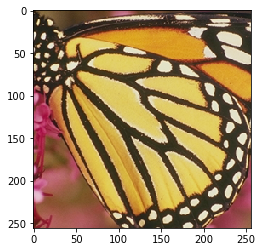

In [47]:
#Ques1
blurred_image, groudtruth_image = preprocess('C:/Users/surface/Desktop/CW1_for_students/CW1_Handout_Template_code/tf-SRCNN/image/butterfly_gray.jpg')
#plt.imshow(groudtruth_image)#尝试使用这里的groudtruth_image出现失真情况，无论输入是否是灰度图像
#考虑使用单纯的读取，因为源文件标注就是butterfly_GT.bmp意指groundtruth
path = 'C:/Users/surface/Desktop/CW1_for_students/CW1_Handout_Template_code/tf-SRCNN/image/butterfly_GT.bmp'
butterfly = scipy.misc.imread(path)#256x256x3 RGB
plt.imshow(butterfly)

C:\Users\surface\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


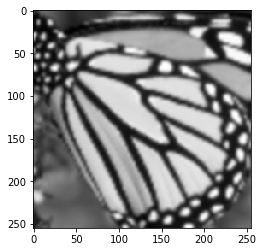

In [49]:
#Ques2
[LR_input, HR_original] = preprocess(path, scale=3)
plt.imshow(LR_input, cmap=plt.get_cmap('gray'))#因为存在失真，尝试利用flatten=FALSE和mode='F'解决，但仍未得到处理，故考虑用灰度形式展现

In [72]:
#=============定义卷积层，valid代表不进行padding。stride中间两个变量是横、纵步长，左右的1先不用管==================
#change the 'inputs' here to 'LR_input' to finish ques3.2
pad = 'VALID'   #针对问题6-9，修改这里为 'SAME'
conv1 = tf.nn.relu(tf.nn.conv2d(inputs, weights['w1'], strides=[1,1,1,1], padding=pad) + biases['b1'])
##------ Add your code here: to compute non-linear mapping
# conv2 layer with biases and relu: 32 filters with size 1 x 1

conv2 = tf.nn.relu(tf.nn.conv2d(conv1, weights['w2'], strides=[1,1,1,1], padding=pad) + biases['b2'])
##------ Add your code here: compute the reconstruction of high-resolution image
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
conv3 = tf.nn.conv2d(conv2, weights['w3'], strides=[1,1,1,1], padding=pad) + biases['b3']

In [73]:
#Ques3
input_ = np.expand_dims(np.expand_dims(blurred_image, axis =0), axis=-1)

In [74]:
#Ques4,开始执行SRCNN
#初始化并sess
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for key in weights.keys():
  sess.run(weights[key].assign(model[key]))

for key in biases.keys():
  sess.run(biases[key].assign(model[key]))

#执行Sess
#通过切换不同的conv可以展示不同层的output，因为这里需要组后的输出，故采用conv3进行sess.run()
ouput_ = sess.run(conv3, feed_dict={inputs: input_})
output = ouput_[0,:,:,0]
sess.close()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


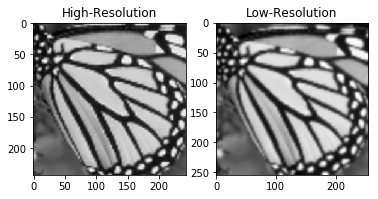

In [75]:
#Ques5 Show the output SR-img of SRCNN 
plt.figure(1)
plt.subplot(1,2,1)
plt.title('High-Resolution')
plt.imshow(output,cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.title('Low-Resolution')
plt.imshow(LR_input, cmap=plt.get_cmap('gray'))
#这里做了可视化对比分析，可见经过SRCNN，分辨率上有了肉眼可见明显的提升

In [64]:
#Ques6 Evaluate the performance:注意，因为存在结构的不同性，若想计算PSNR，必须保证输入输出的图像大小相同，故这里强制使用padding=SAME
    #HINT!here we must use padding ='SAME', otherwise we eill loss 12 pixels per col and row 
#=============TO CALCULATE THE PSNR OF GroundTRUTH and SRCNN-OUTPUT============
#运行前:回到 “卷积层定义“ 这一行，修改pad='SAME'后重新顺序执行以上4个代码块
diff = output - groudtruth_image
rmse = np.sqrt(np.sum(diff**2))/len(output)
psnr = 20*np.log10(255/rmse)     #max/rmse
print(psnr)

68.83908060219161


In [65]:
#Ques7 Use bicubic to enlarge the output pic
diff_baseline = bicubic_butterfly_re - butterfly_gray
psnr_baseline =  20*np.log10(255/(np.sqrt(np.sum(diff_baseline**2))/len(bicubic_butterfly_re)))
print(psnr_baseline)

22.69174120407474


22.69174120407474


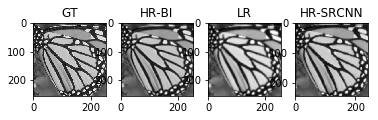

In [79]:
#Ques8 Compare psnr
#可以使用以下的skimage.measure.compare_psnr函数，结果和上述Ques7里的psnr_baseline一样
#在执行这里之前，还需要把pad='SAME'再改回VALID,否则又会失真
#psnr_scikit = skimage.measure.compare_psnr(bicubic_butterfly_re,butterfly_gray)
plt.figure(1)
plt.subplot(1,4,1)
plt.title('GT')
plt.imshow(groudtruth_image,cmap=plt.get_cmap('gray'))

plt.figure(1)
plt.subplot(1,4,2)
plt.title('HR-BI')
plt.imshow(bicubic_butterfly_re,cmap=plt.get_cmap('gray'))

plt.figure(1)
plt.subplot(1,4,3)
plt.title('LR')
plt.imshow(LR_input,cmap=plt.get_cmap('gray'))

plt.figure(1)
plt.subplot(1,4,4)
plt.title('HR-SRCNN')
plt.imshow(output,cmap=plt.get_cmap('gray'))
print(psnr_baseline)

In [ ]:
#Ques9: SRCNN的PSNR高，说明好，回答如下
#ANS: Here the result of 'psnr_baseline' = ' psnr_scikit', which represent the 
#result of baseline_bicubic. The SRCNN-PSNR result is saved as 'psnr'
#psnr ~=68.88  and psnr_baseline ~=22.04. So the result of SRCNN is better than Baseline